In [3]:
import ROOT
import math
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


## Define fitting procedure

In [4]:
from scipy.interpolate import interp2d


class Interaction:
    """Pointing information about a particular type of interaction (such as electron scattering)."""
    name: str
    energy_min:         float
    energy_max:         float
    energy_binwidth:    float

    cosAngle_min:       float
    cosAngle_max:       float
    cosAngle_binwidth:  float

    pdf:                np.ndarray
    pdf_linear:         Callable
    pdf_cubic:          Callable

    def __init__(self, name, energy_binning, cosAngle_binning, pdf):
        self.name = name
        (self.energy_min, self.energy_max, self.energy_binwidth) = energy_binning
        (self.cosAngle_min, self.cosAngle_max, self.cosAngle_binwidth) = cosAngle_binning
        self.pdf = pdf
        energy_coords = np.arange(0, len(pdf))
        cosAngle_coords = np.arange(0, len(pdf[0]))
        self.pdf_linear = interp2d(energy_coords, cosAngle_coords, np.transpose(pdf), 
                bounds_error=False, fill_value=None, kind='linear')
        self.pdf_cubic  = interp2d(energy_coords, cosAngle_coords, np.transpose(pdf), 
                bounds_error=False, fill_value=None, kind='cubic')


def load_pdf(pdf_path, name=None):
    with open(pdf_path) as f:
        energy_binning = np.loadtxt(f, max_rows=1)
        cosAngle_binning = np.loadtxt(f, max_rows=1)
        pdf = np.loadtxt(f)
    # return energy_binning, cosAngle_binning, pdf
    return Interaction(name, energy_binning, cosAngle_binning, pdf)


ES = load_pdf("/media/linux_store/hep/data/pdf/ES_gvkm_clean_0127_pdf.dat", name="ES")
CC = load_pdf("/media/linux_store/hep/data/pdf/CC_gvkm_clean_0127_pdf.dat", name="CC")

      



In [5]:
def charge_to_energy_clean(charge):
    m = 259.218
    b = 901.312
    return (charge - b)/m


def load_SN_file(filepath):
    file = ROOT.TFile(filepath)
    tree = file.PointResTree.tr
    # nevts = tree.GetEntries()
    energies = []
    directions = []

    ievt = 0
    for event in tree:
        if(event.NTrks == 0):
            continue
        energies.append(charge_to_energy_clean(event.charge_corrected))

        directions.append([
            event.reco_e_dir.X(),
            event.reco_e_dir.Y(),
            event.reco_e_dir.Z()
        ])
        ievt += 1
    return np.asarray(energies), np.asarray(directions)


def get_truth_SN_dir(filepath):
    file = ROOT.TFile(filepath)
    tree = file.PointResTree.tr
    for event in tree:
        return np.array([event.truth_nu_dir.Theta(), event.truth_nu_dir.Phi()])


def sphere_to_xyz(direction):
    # [theta, phi] -> [x, y, z]
    return np.array([
        math.sin(direction[0])*math.cos(direction[1]),
        math.sin(direction[0])*math.sin(direction[1]),
        math.cos(direction[0])
    ])



In [6]:


class Supsernova_Pointing:
    """Class used to hold information about each supernova, and generate its loss function.
    """
    # Parallel list corresponding to each type of interaction
    interactions:   list[Interaction]
    # tuple is [energy, direction]
    events_per_interaction:      list[tuple[np.ndarray, np.ndarray]]
    weights:        list[float]
    truth_dir:      np.ndarray
    default_interpolation_type:  str

    def __init__(self, interactions, sn_event_files, default_interpolation_type=None, weights=None):
        """Class Constructor

        Args:
            interactions (list[Interaction]): List of interaction information objects.
            sn_event_files (list[str]): List of paths to ROOT files associated to each interaction.
            default_interpolation_type (str, optional): Type of interpolation. Can be None (no interpolation), 'linear', or 'cubic. Defaults to None.
            weights (list[float], optional): Weight of each interaction. If None, they are all set to 1. Defaults to None.
        """
        self.interactions = interactions
        self.events_per_interaction = []
        for path in sn_event_files:
            self.events_per_interaction.append(load_SN_file(path))
        self.truth_dir = get_truth_SN_dir(sn_event_files[0])
        self.weights = [1.0]*len(self.events_per_interaction) if weights==None else weights
        
        assert default_interpolation_type in [None, 'cubic', 'linear'], "Invalid interpolation type."
        self.default_interpolation_type = default_interpolation_type


    def loss(self, SN_dir, interpolation_override=None, weighting_factor=0):
        """loss function to minimize

        Args:
            SN_dir (np.ndarray): Guessed direction of the neutrino in format [theta, phi]
            interpolation_override (str, optional): Override interpolation of default type. Defaults to default_interpolation_type.
            weighting_factor (float, optional): A linear weighting factor. Each energy bin is weighted by (1+ energy_bin*weighting factor). Defaults to 0.
        """
        SN_dir_xyz = sphere_to_xyz(SN_dir)
        loss = 0
        interpolation = interpolation_override if interpolation_override != None else self.default_interpolation_type
        assert interpolation in [None, 'cubic', 'linear'], "Invalid interpolation type."

        for interaction, events, weight in zip(self.interactions, self.events_per_interaction, self.weights):
            interaction_loss = 0
            energies  = events[0]
            cosAngles = events[1].dot(SN_dir_xyz)
            for energy, cosAngle in zip(energies, cosAngles):
                # # treat overly energetic events as having the same energy as PDF maxima
                if energy >= interaction.energy_max:
                    pdf_value = 1.0
                else:
                    if energy < 10: continue
                    energy_bin = (energy - interaction.energy_min)/interaction.energy_binwidth

                    cosAngle_bin = (cosAngle - interaction.cosAngle_min)/interaction.cosAngle_binwidth
                    cosAngle_bin = min(cosAngle_bin, len(cosAngles)-1) # guard against cosAngle = 1
                    if interpolation == None:
                        pdf_value = interaction.pdf[int(energy_bin), int(cosAngle_bin)]
                    elif interpolation == 'linear':
                        pdf_value = interaction.pdf_linear(energy_bin, cosAngle_bin)[0]
                    elif interpolation == 'cubic':
                        pdf_value = interaction.pdf_cubic(energy_bin, cosAngle_bin)[0]
                
                pdf_value *= (1 + energy_bin * weighting_factor)

                # interaction_loss -= np.sqrt(pdf_value) if pdf_value>0 else 0
                # interaction_loss += - np.log(pdf_value) if pdf_value > 0 else 10
                interaction_loss -= pdf_value
            loss += interaction_loss * weight
        return loss

            

In [7]:
# Testing with a single file
import os


directory = "/media/linux_store/hep/data/SN/"

from scipy.optimize import brute, fmin
SN_pointer = Supsernova_Pointing([ES], [directory + "/ES_ana/ES_PointResTree_52828358_11.root"])
def loss_func(x):
    return SN_pointer.loss(x, interpolation_override=None)
print(SN_pointer.interactions[0].pdf.shape)
res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
print(res[0])
print(SN_pointer.truth_dir)
print(f"Loss = {loss_func(SN_pointer.truth_dir)}")

(7, 20)
[0.856798   0.72986496]
[1.03487709 0.77481472]
Loss = -11.250554876604358


ES Only: [0.856798   0.82506474]

10.413331870560805

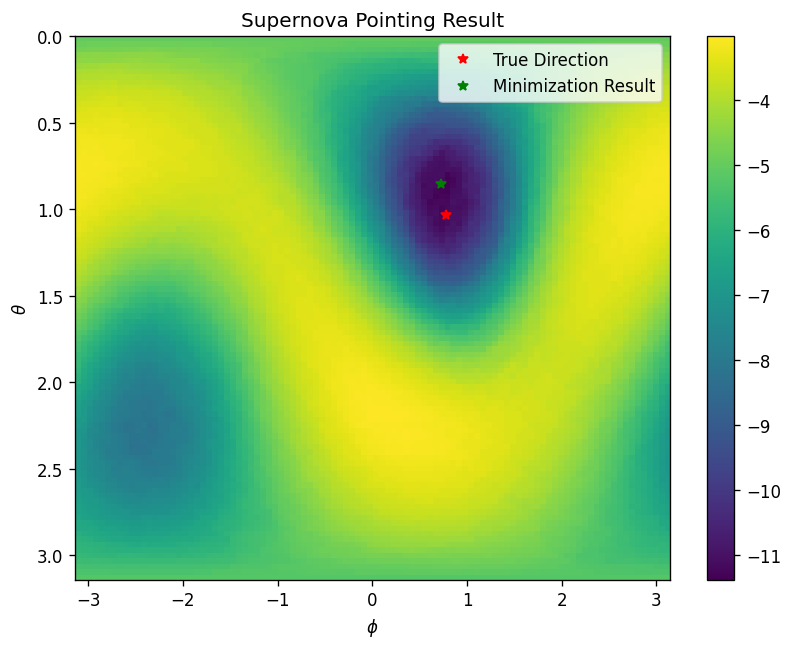

In [8]:
def error(pointer: Supsernova_Pointing, result, full_output = False, unit='deg'):
    assert unit in ['rad', 'deg'], "Unit must be deg or rad."
    if full_output:
        x0 = result[0]
    else:
        x0 = result
    
    angle = np.arccos(sphere_to_xyz(pointer.truth_dir).dot(sphere_to_xyz(x0)))
    return angle if unit=='rad' else angle*180/np.pi

def details(pointer: Supsernova_Pointing, result: tuple):
    # result [x0, fval, grid, jout]
    (x0, fval, grid, jout) = result
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(jout, extent=[-np.pi, np.pi, np.pi, 0], origin='upper', aspect='auto')
    plt.plot(pointer.truth_dir[1], pointer.truth_dir[0], 'r*', label="True Direction")
    plt.plot(x0[1], x0[0], 'g*', label='Minimization Result')
    plt.colorbar()
    plt.legend()
    plt.title('Supernova Pointing Result')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\theta$')
    dot = sphere_to_xyz(pointer.truth_dir).dot(sphere_to_xyz(x0))
    
    # return degree deviation between minimization and truth
    return np.arccos(dot)*180/np.pi

details(SN_pointer, res)
# error(SN_pointer, res)



## Batch fitting

In [9]:
# Parse files

# directory = "/media/linux_store/hep/data/SN/"

ES_files = os.listdir(directory + "ES_ana")
CC_files = os.listdir(directory + "CC_ana")
SN_file_tuples = []
for ES_file in ES_files:
    CC_file = ES_file.replace('ES', 'CC')
    if(CC_file) in CC_files:
        SN_file_tuples.append((
            directory + "ES_ana/" + ES_file,
            directory + "CC_ana/" + CC_file
        ))
        continue
    ## Corresponding CC File doesnt exist
    # print(f"Corresponding CC File not found for {ES_file}.")

print(f"Found {len(SN_file_tuples)} supernova files")

Found 905 supernova files


In [10]:
# Do all the fits

# errors = []
# from tqdm import tqdm, trange
# for SN_file_tuple in tqdm(SN_file_tuples):
#     SN_pointer = Supsernova_Pointing([ES], [SN_file_tuple[0]])

#     def loss_func(x):
#         return SN_pointer.loss(x, interpolation_override=None)
#     res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=20, 
#                 full_output=False, workers=6, finish=fmin)
#     errors.append(error(SN_pointer, res))
    
# plt.hist(errors)
# plt.title("Angle between reco and truth SN direction (ES only, clean)")
# plt.xlabel("Degrees")
# np.quantile(errors, 0.66)

In [13]:
# Hyper parameter search for a fit
from tqdm import tqdm, trange
def weight_search(w):
    errors = []
    for SN_file_tuple in tqdm(SN_file_tuples, leave=False):
        SN_pointer = Supsernova_Pointing([ES], [SN_file_tuple[0]])

        def loss_func(x):
            return SN_pointer.loss(x, interpolation_override=None, weighting_factor=w)
        res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                    full_output=False, workers=6, finish=fmin)
        errors.append(error(SN_pointer, res))
    return np.quantile(errors, 0.66)

weights = np.arange(0.0, 1, 0.2)
error_for_weight = []
for w in weights:
    errors = []
    for SN_file_tuple in tqdm(SN_file_tuples, desc=f"Weight = {w}"):
        SN_pointer = Supsernova_Pointing([ES], [SN_file_tuple[0]])

        def loss_func(x):
            return SN_pointer.loss(x, interpolation_override=None, weighting_factor=w)
        res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                    full_output=False, workers=10, finish=fmin)
        errors.append(error(SN_pointer, res))
    print(np.quantile(errors, 0.66))
    error_for_weight.append(np.quantile(errors, 0.66))

Weight = 0.0: 100%|██████████| 905/905 [01:48<00:00,  8.31it/s]


7.443128101644091


Weight = 0.2: 100%|██████████| 905/905 [01:48<00:00,  8.30it/s]


7.397397266620088


Weight = 0.4: 100%|██████████| 905/905 [01:48<00:00,  8.35it/s]


7.3330835499922316


Weight = 0.6000000000000001: 100%|██████████| 905/905 [01:42<00:00,  8.84it/s]


7.281813051837022


Weight = 0.8: 100%|██████████| 905/905 [01:42<00:00,  8.84it/s]


7.264279050982504


In [14]:
weights = np.arange(1.0, 2.2, 0.2)
error_for_weight = []
for w in weights:
    errors = []
    for SN_file_tuple in tqdm(SN_file_tuples, desc=f"Weight = {w}"):
        SN_pointer = Supsernova_Pointing([ES], [SN_file_tuple[0]])

        def loss_func(x):
            return SN_pointer.loss(x, interpolation_override=None, weighting_factor=w)
        res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                    full_output=False, workers=10, finish=fmin)
        errors.append(error(SN_pointer, res))
    print(np.quantile(errors, 0.66))
    error_for_weight.append(np.quantile(errors, 0.66))

Weight = 1.0: 100%|██████████| 905/905 [01:51<00:00,  8.11it/s]


7.297865887109069


Weight = 1.2: 100%|██████████| 905/905 [01:49<00:00,  8.24it/s]


7.2878992754444525


Weight = 1.4: 100%|██████████| 905/905 [01:49<00:00,  8.26it/s]


7.28551586107534


Weight = 1.5999999999999999: 100%|██████████| 905/905 [01:50<00:00,  8.20it/s]


7.28551586107534


Weight = 1.7999999999999998: 100%|██████████| 905/905 [01:49<00:00,  8.30it/s]


7.28551586107534


Weight = 1.9999999999999998: 100%|██████████| 905/905 [01:49<00:00,  8.30it/s]


7.26910832033936


Weight = 2.1999999999999997: 100%|██████████| 905/905 [01:50<00:00,  8.17it/s]


7.235546535189784


In [15]:
weights = np.arange(2.5, 7.5, 0.5)
error_for_weight = []
for w in weights:
    errors = []
    for SN_file_tuple in tqdm(SN_file_tuples, desc=f"Weight = {w}"):
        SN_pointer = Supsernova_Pointing([ES], [SN_file_tuple[0]])

        def loss_func(x):
            return SN_pointer.loss(x, interpolation_override=None, weighting_factor=w)
        res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                    full_output=False, workers=10, finish=fmin)
        errors.append(error(SN_pointer, res))
    print(np.quantile(errors, 0.66))
    error_for_weight.append(np.quantile(errors, 0.66))

Weight = 2.5: 100%|██████████| 905/905 [01:48<00:00,  8.37it/s]


7.243512304420289


Weight = 3.0: 100%|██████████| 905/905 [01:49<00:00,  8.29it/s]


7.227836539462238


Weight = 3.5: 100%|██████████| 905/905 [01:48<00:00,  8.32it/s]


7.227836539462238


Weight = 4.0: 100%|██████████| 905/905 [01:48<00:00,  8.32it/s]


7.216957761132664


Weight = 4.5: 100%|██████████| 905/905 [01:49<00:00,  8.26it/s]


7.217688326282483


Weight = 5.0: 100%|██████████| 905/905 [01:55<00:00,  7.86it/s]


7.217688326282483


Weight = 5.5: 100%|██████████| 905/905 [01:44<00:00,  8.64it/s]


7.2157606769828355


Weight = 6.0: 100%|██████████| 905/905 [01:52<00:00,  8.06it/s]


7.216957761132664


Weight = 6.5: 100%|██████████| 905/905 [01:54<00:00,  7.89it/s]


7.216957761132664


Weight = 7.0:   1%|          | 8/905 [00:01<02:16,  6.56it/s]


KeyboardInterrupt: 